In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
from keras import Sequential

ISLP 10.10.6

Consider the simple function $R(\beta) = sin(\beta) + \beta/10.$

(a) Draw a graph of this function over the range $\beta \in [-6,6].$ <br>
(b) What is the derivative of this function? <br>
(c) Given $\beta^0 = 2.3$, run gradient descent to find a local minimum of $R(\beta)$ using a learning rate of $\rho = 0.1.$ Show each of $\beta^0, \beta^1, \ldots$ in your plot, as well as the final answer. <br>
(d) Repeat with $\beta^0 = 1.4.$

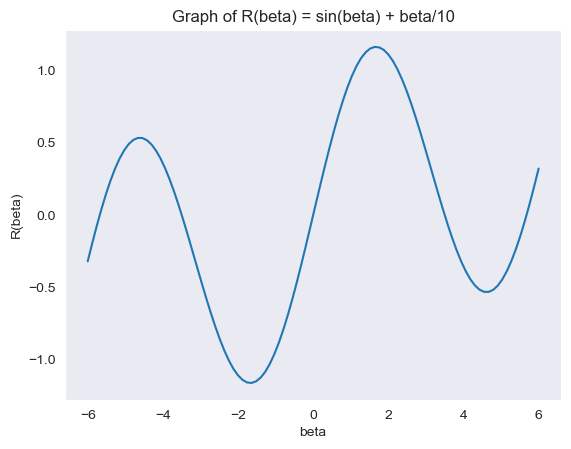

In [2]:
# (a)
beta = np.linspace(-6, 6, 100)
R = np.sin(beta) + beta / 10

plt.plot(beta, R)
plt.title("Graph of R(beta) = sin(beta) + beta/10")
plt.xlabel("beta")
plt.ylabel("R(beta)")
plt.grid()
plt.show()

In [3]:
# (b)
from sympy import symbols, diff, sin
beta = symbols('beta')
R = sin(beta) + beta / 10
R_derivative = diff(R, beta)
R_derivative

cos(beta) + 1/10

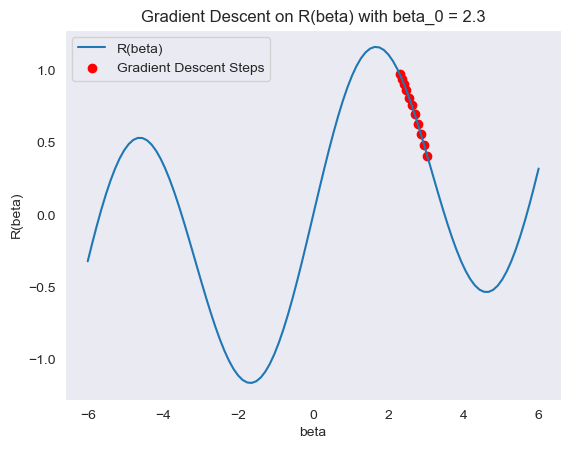

Final beta after gradient descent starting from 2.3: 3.039778527802761


In [4]:
# (c)
def gradient_descent(beta_0, learning_rate, iterations):
    beta = beta_0
    betas = [beta]
    for _ in range(iterations):
        gradient = np.cos(beta) + 1 / 10
        beta -= learning_rate * gradient
        betas.append(beta)
    return betas

# Parameters
beta_0 = 2.3
learning_rate = 0.1
iterations = 10
betas = gradient_descent(beta_0, learning_rate, iterations)

# Plotting
beta = np.linspace(-6, 6, 100)
R_numeric = np.sin(beta) + beta / 10  # Use numerical R(beta) for plotting

# Plotting
plt.plot(beta, R_numeric, label="R(beta)")
plt.scatter(betas, [np.sin(b) + b / 10 for b in betas], color='red', label='Gradient Descent Steps')
plt.title("Gradient Descent on R(beta) with beta_0 = 2.3")
plt.xlabel("beta")
plt.ylabel("R(beta)")
plt.grid()
plt.legend()
plt.show()

# Final answer
final_beta = betas[-1]
print(f"Final beta after gradient descent starting from 2.3: {final_beta}")

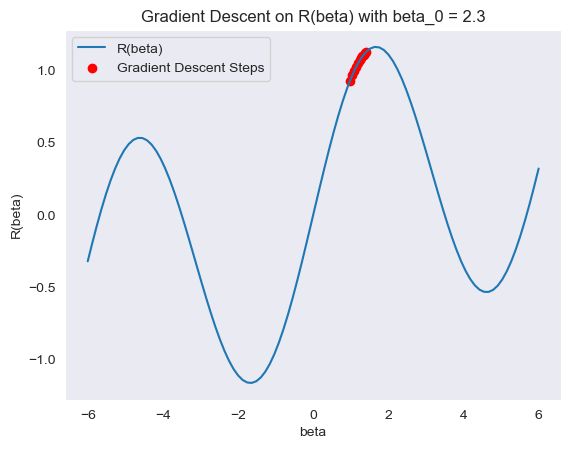

Final beta after gradient descent starting from 2.3: 0.978529151020619


In [5]:
# (d)
beta_0 = 1.4
betas = gradient_descent(beta_0, learning_rate, iterations)

# Plotting
plt.plot(beta, R_numeric, label="R(beta)")
plt.scatter(betas, [np.sin(b) + b / 10 for b in betas], color='red', label='Gradient Descent Steps')
plt.title("Gradient Descent on R(beta) with beta_0 = 2.3")
plt.xlabel("beta")
plt.ylabel("R(beta)")
plt.grid()
plt.legend()
plt.show()

# Final answer
final_beta = betas[-1]
print(f"Final beta after gradient descent starting from 2.3: {final_beta}")

ISLP 10.10.8

From your collection of personal photographs, pick 10 images of animals (such a dogs, cats, birds, farm animals, etc.)... Now train a pretrained image classification CNN as in Lab 10.9.4 to predict the class of each of your images, and report the probabilities for the top five predicted classes for each image.

In [6]:
import os
import cv2
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop, ToTensor)

In [7]:
# load images
image_dir = 'images'
image_paths = [
    os.path.join(image_dir, filename)
    for filename in os.listdir(image_dir)
    if filename.endswith('.jpeg') or filename.endswith('.png')
]

In [8]:
# load model
resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)

In [9]:
import torch
from torchvision.io import read_image

# preprocess images
resize = Resize((224, 224))
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Read and preprocess images to ensure all images have the same number of channels
imgs = []
for f in image_paths:
    img = read_image(f)
    if img.size(0) == 4:  # Check if the image has 4 channels (RGBA)
        img = img[:3, :, :]  # Discard the alpha channel
    img = resize(img.float() / 255)  # Normalize pixel values to [0, 1]
    img = normalize(img)
    imgs.append(img)

# Stack images into a single tensor
imgs = torch.stack(imgs)

print(imgs.size())

torch.Size([8, 3, 224, 224])


In [10]:
# set mode to eval
resnet50.eval()

# feed images through fitted network
img_preds = resnet50(imgs)

In [11]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [12]:
import json

labs = json.load(open('imagenet_class_index.json'))  # from s3.amazonaws.com/deep-learning- models/image-models/imagenet_class_index.json
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in labs.items()], columns=['idx', 'label'])
class_labels = class_labels.sort_values(by='idx').reset_index(drop=True)

In [13]:
for i, (img, path) in enumerate(zip(imgs, image_paths)):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:5]
    print(f'Image: {path}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: images/horse.png
   index       label      prob
0    339      sorrel  0.194791
1    912  worm_fence  0.033121
2    515  cowboy_hat  0.009576
3    808    sombrero  0.005492
4    603  horse_cart  0.004703
Image: images/cow.jpeg
   index          label      prob
0    345             ox  0.675593
1    690         oxcart  0.010072
2    351     hartebeest  0.003943
3    346  water_buffalo  0.003715
4    912     worm_fence  0.003641
Image: images/Cottontail.jpeg
   index             label      prob
0    330       wood_rabbit  0.432307
1    331              hare  0.076728
2    266  miniature_poodle  0.000980
3     60       night_snake  0.000920
4    356            weasel  0.000919
Image: images/blackcat.jpeg
   index         label      prob
0    285  Egyptian_cat  0.043905
1    636       mailbag  0.029419
2    785     seat_belt  0.025962
3    414      backpack  0.022181
4    284   Siamese_cat  0.021619
Image: images/blackrabbit.png
   index         label      prob
0    332        Angora